Files already downloaded and verified
Files already downloaded and verified
Training starts now: 
Epoch [1/4], Step [100/12500], Loss: 2.2855, Accuracy: 0.00%
Epoch [1/4], Step [200/12500], Loss: 2.2938, Accuracy: 0.00%
Epoch [1/4], Step [300/12500], Loss: 2.3010, Accuracy: 0.00%
Epoch [1/4], Step [400/12500], Loss: 2.2875, Accuracy: 25.00%
Epoch [1/4], Step [500/12500], Loss: 2.2946, Accuracy: 0.00%
Epoch [1/4], Step [600/12500], Loss: 2.3114, Accuracy: 0.00%
Epoch [1/4], Step [700/12500], Loss: 2.3647, Accuracy: 0.00%
Epoch [1/4], Step [800/12500], Loss: 2.2082, Accuracy: 25.00%
Epoch [1/4], Step [900/12500], Loss: 2.2357, Accuracy: 25.00%
Epoch [1/4], Step [1000/12500], Loss: 2.1277, Accuracy: 25.00%
Epoch [1/4], Step [1100/12500], Loss: 1.5174, Accuracy: 25.00%
Epoch [1/4], Step [1200/12500], Loss: 1.9016, Accuracy: 0.00%
Epoch [1/4], Step [1300/12500], Loss: 1.8747, Accuracy: 50.00%
Epoch [1/4], Step [1400/12500], Loss: 2.9252, Accuracy: 0.00%
Epoch [1/4], Step [1500/12500], Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [4/4], Step [12500/12500], Loss: 0.4844, Accuracy: 75.00%
Training finished


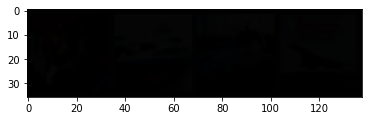

Real Class:    cat  ship  ship plane
Predicted Class:    cat  ship  ship plane
Test Accuracy of the model on the 10000 test images: 70.04 %
Accuracy of plane : 81 %
Accuracy of   car : 84 %
Accuracy of  bird : 62 %
Accuracy of   cat : 53 %
Accuracy of  deer : 52 %
Accuracy of   dog : 50 %
Accuracy of  frog : 75 %
Accuracy of horse : 82 %
Accuracy of  ship : 81 %
Accuracy of truck : 74 %


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import freeze_support
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import joblib

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Den 8a valw num_workers

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)


def imshow(img):
    img = img / 50 + 0.005  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(16 * 8 * 8, 1000)
        self.fc2 = nn.Linear(1000, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        joblib.dump(out, 'recognition.pkl')
        return out


net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print('Training starts now: ')
if __name__ == '__main__':
    # Train the model
    total_step = len(trainloader)
    loss_list = []
    acc_list = []
    for epoch in range(4):
        for i, (images, labels) in enumerate(trainloader):
            # Run the forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, 4, i + 1, total_step, loss.item(),
                              (correct / total) * 100))

    # Small Test
print('Training finished')
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Real Class: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted Class: ', ' '.join('%5s' % classes[predicted[j]]
                                    for j in range(4)))

net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))